# Merging Climate Datasets Exercise

Work through this notebook to practice harmonizing and merging two climate datasets that differ in temporal cadence and spatial resolution.

You will: 
- Load two public NOAA datasets directly from the cloud
- Subset to the continental US (use 230°E–300°E in longitude since the data span 0–360°)
- Use `xr.resample` to aggregate time and `xr.interp` to match grids
- Combine the variables with `xr.merge` for joint analysis

Refer back to the answer key after attempting each step.


## 1. Setup


In [49]:
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    from cartopy.util import add_cyclic_point
except ImportError:
    ccrs = None
    cfeature = None

TEMP_URL = "https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.2020.nc"
PRECIP_URL = "https://psl.noaa.gov/thredds/dodsC/Datasets/cpc_global_precip/precip.2020.nc"

LAT_RANGE = slice(50, 20)  # degrees North
LON_RANGE_360 = slice(230, 300)  # degrees East (equivalent to -130° to -60°)
LON_RANGE_180 = slice(-130, -60)  # convenience if a dataset uses -180° to 180°

TIME_RANGE = slice("2020-06-01", "2020-06-30")


## 2. Load the datasets

Open both remote datasets with `xr.open_dataset`, passing a reasonable chunk size for the time dimension. Assign the resulting objects to `air` and `precip`.


In [22]:
# TODO: load the air temperature and precipitation datasets.
# Example: air = xr.open_dataset(..., chunks={"time": 8})

air = xr.open_dataset(TEMP_URL, chunks={"time": 8})
precip = xr.open_dataset(PRECIP_URL, chunks={"time": 8})

#raise NotImplementedError("Assign datasets to `air` and `precip`.")


## 3. Subset to the continental United States and June 2020

Select the bounding box provided above and limit the time range to June 2020 for both datasets. Store the results in `air_us` and `precip_us`.
Remember that longitude runs from 0° to 360°, so select 230°E–300°E. Check whether each coordinate is ascending or descending before building the slice.


In [23]:
# TODO: subset both datasets using `sel`, handling coordinate ordering as needed.
#raise NotImplementedError("Create `air_us` and `precip_us`.")

air_us = air.sel(lon=LON_RANGE_360, lat=LAT_RANGE, time=TIME_RANGE)
precip_us = precip.sel(lon=LON_RANGE_360, lat=LAT_RANGE, time=TIME_RANGE)


## 4. Align temporal cadence

Aggregate the six-hourly air temperatures to daily means with `xr.resample`. Name the resulting DataArray `air_daily`.


In [24]:
# TODO: use xr.resample to create daily means.
#raise NotImplementedError("Create `air_daily`.")


air_daily = (
    air_us['air']
    .resample({'time': '1D'}, 
                label='left', # Label using 00UTC day.
                closed='left') # 00UTC time is inclusive
                               # for daily mean.
    .mean()
    )


## 5. Interpolate to the precipitation grid

Use `xr.interp` to interpolate the daily air temperatures onto the precipitation grid (`precip_us.lat` and `precip_us.lon`). Store the interpolated result in `air_interp`.


In [25]:
# TODO: interpolate the resampled temperature field onto the precipitation grid.
#raise NotImplementedError("Create `air_interp`.")

air_interp = air_daily.interp(lat=precip_us.lat, lon=precip_us.lon)

In [26]:
print(air_interp)

<xarray.DataArray 'air' (time: 30, lat: 60, lon: 140)> Size: 1MB
dask.array<transpose, shape=(30, 60, 140), dtype=float32, chunksize=(1, 60, 140), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 240B 2020-06-01 2020-06-02 ... 2020-06-30
  * lat      (lat) float32 240B 49.75 49.25 48.75 48.25 ... 21.25 20.75 20.25
  * lon      (lon) float32 560B 230.2 230.8 231.2 231.8 ... 298.8 299.2 299.8
Attributes: (12/13)
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    ...            ...
    parent_stat:   Other
    valid_range:   [185.16 331.16]
    dataset:       NCEP Reanalysis
    actual_range:  [188.6 324.1]
    level_desc:    0.995 sigma
    _ChunkSizes:   [  1  73 144]


## 6. Merge the datasets

Convert the aligned arrays into datasets with clear variable names and merge them with `xr.merge`. Save the output as `merged`.


In [30]:
# TODO: build datasets and merge them into one object named `merged`.
#raise NotImplementedError("Create `merged`.")

merged = xr.merge([air_interp, precip_us])


## 7. Inspect your result

Once your pipeline runs without `NotImplementedError`, evaluate the following cell to sanity-check the merged dataset.


In [31]:
# The assertions below should pass once you have completed the exercise.
assert set(merged.data_vars) == {"air", "precip"}
assert merged.air.dims == merged.precip.dims
print(merged)


<xarray.Dataset> Size: 2MB
Dimensions:  (time: 30, lat: 60, lon: 140)
Coordinates:
  * time     (time) datetime64[ns] 240B 2020-06-01 2020-06-02 ... 2020-06-30
  * lat      (lat) float32 240B 49.75 49.25 48.75 48.25 ... 21.25 20.75 20.25
  * lon      (lon) float32 560B 230.2 230.8 231.2 231.8 ... 298.8 299.2 299.8
Data variables:
    air      (time, lat, lon) float32 1MB dask.array<chunksize=(1, 60, 140), meta=np.ndarray>
    precip   (time, lat, lon) float32 1MB dask.array<chunksize=(8, 60, 140), meta=np.ndarray>
Attributes: (12/13)
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    ...            ...
    parent_stat:   Other
    valid_range:   [185.16 331.16]
    dataset:       NCEP Reanalysis
    actual_range:  [188.6 324.1]
    level_desc:    0.995 sigma
    _ChunkSizes:   [  1  73 144]


## 8. Check In

- Render both variables at the first timestep on a `cartopy` map to verify alignment visually (PlateCarree works well).
- Build a scatter plot comparing colocated temperature and precipitation values across the merged domain.
- Save the merged output with `to_netcdf` for future analysis.


In [33]:
# Load data for first timestep
air_temp1 = merged['air'][0,:,:].compute()
precip1 = merged['precip'][0,:,:].compute()

## Cartopy Plot

Text(0.5, 1.0, 'Daily Precip on 06-01-2020')

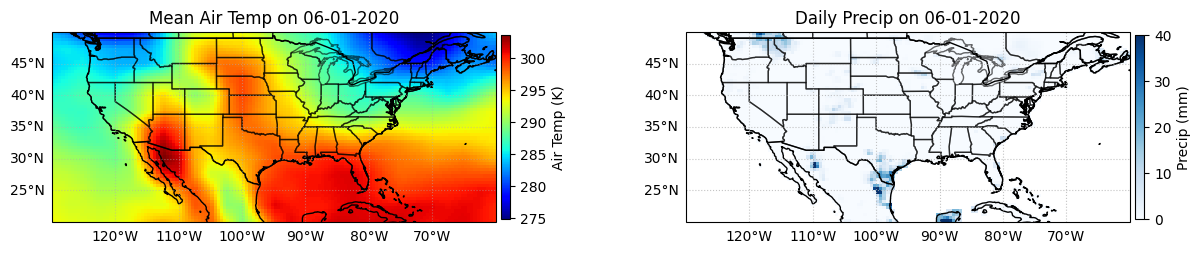

In [ ]:
proj=ccrs.PlateCarree() # Map projection

#Create a figure
fig, ax = plt.subplots(figsize=(15,15), ncols=2, subplot_kw=dict(projection=proj))

################### Temp plot ####################
a = ax[0].pcolormesh(air_temp1.lon, air_temp1.lat, air_temp1, transform=proj, cmap='jet')

# Create our colorbar
cb1 = fig.colorbar(a,shrink=0.16, pad=0.01)
cb1.set_label('Air Temp (K)')

# Gridlines
gl = ax[0].gridlines(alpha=0.5, linestyle=':', draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# Add map features
ax[0].add_feature(cfeature.STATES, edgecolor="black", linewidths=1, alpha=0.6)
ax[0].add_feature(cfeature.COASTLINE, edgecolor="black")
ax[0].add_feature(cfeature.BORDERS, edgecolor="black")

# Add a title
ax[0].set_title(f'Mean Air Temp on {pd.to_datetime(air_temp1.time.values).strftime("%m-%d-%Y")}')

################### Precip plot #####################
a = ax[1].pcolormesh(precip1.lon, precip1.lat, precip1, transform=proj, cmap='Blues', vmin=0, vmax=40)

# Create our colorbar
cb2 = fig.colorbar(a,shrink=0.16, pad=0.01)
cb2.set_label('Precip (mm)')

# Gridlines
gl = ax[1].gridlines(alpha=0.75, linestyle=':', draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# Add map features
ax[1].add_feature(cfeature.STATES, edgecolor="black", linewidths=1, alpha=0.6)
ax[1].add_feature(cfeature.COASTLINE, edgecolor="black")
ax[1].add_feature(cfeature.BORDERS, edgecolor="black")

# Add a title
ax[1].set_title(f'Daily Precip on {pd.to_datetime(air_temp1.time.values).strftime("%m-%d-%Y")}')